In [1]:
#导入需要的包
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
import pickle

%matplotlib inline

f:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 数据读取加载

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_store = pd.read_csv("data/store.csv")

df_train.head()

f:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


# 特征工程之 数据异常值处理    

In [3]:
#df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace = True)

In [3]:
df_store.fillna(0,inplace=True)

In [4]:
df_test.fillna(1,inplace=True)

In [5]:
train_store=pd.merge(df_train,df_store,on='Store')
test_store=pd.merge(df_test,df_store,on='Store')

In [6]:
corr=train_store.corr()['Sales']
print('{:*^30}'.format('正相关前10的列'))
print(corr.sort_values(ascending=False)[:10])
print('{:*^30}'.format('负相关前10的列'))
print(corr.sort_values()[:10])

***********正相关前10的列***********
Sales                        1.000000
Customers                    0.894711
Open                         0.678472
Promo                        0.452345
SchoolHoliday                0.085124
Store                        0.005126
CompetitionOpenSinceYear     0.002749
CompetitionOpenSinceMonth   -0.012431
CompetitionDistance         -0.018609
Promo2SinceWeek             -0.044143
Name: Sales, dtype: float64
***********负相关前10的列***********
DayOfWeek                   -0.462125
Promo2SinceYear             -0.091056
Promo2                      -0.091040
Promo2SinceWeek             -0.044143
CompetitionDistance         -0.018609
CompetitionOpenSinceMonth   -0.012431
CompetitionOpenSinceYear     0.002749
Store                        0.005126
SchoolHoliday                0.085124
Promo                        0.452345
Name: Sales, dtype: float64


In [7]:
#数据划分
train = train_store.sort_values(['Date'],ascending = False)
train_total = train.copy()

split_index = 6*7*1115
valid = train[:split_index]
train = train[split_index:]

# only use data of Sales>0 and Open is 1
valid = valid[(valid.Open != 0)&(valid.Sales >0)]
train = train[(train.Open != 0)&(train.Sales >0)]
train_total = train_total[(train_total.Open != 0)&(train_total.Sales >0)]
valid_tmp=valid.copy()

In [34]:
train_total.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales
0,1,5,1,0,1,3,1,1270.0,9.0,2008.0,...,0.0,0.0,2015,7,31,31,82.0,24187.75,0,5263
1,1,4,1,0,1,3,1,1270.0,9.0,2008.0,...,0.0,0.0,2015,7,30,31,82.0,24187.75,0,5020
2,1,3,1,0,1,3,1,1270.0,9.0,2008.0,...,0.0,0.0,2015,7,29,31,82.0,24187.75,0,4782
3,1,2,1,0,1,3,1,1270.0,9.0,2008.0,...,0.0,0.0,2015,7,28,31,82.0,24187.75,0,5011
4,1,1,1,0,1,3,1,1270.0,9.0,2008.0,...,0.0,0.0,2015,7,27,31,82.0,24187.75,0,6102


# 特征工程之 数据转换、特征提取    

In [8]:
#特征处理与转化，定义特征处理函数
#包括对含有字符数据的独热编码
def transfer_feature(data):
    # 标签编码
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #将时间特征进行拆分和转化，并加入'WeekOfYear'特征
    data['Year']  =  pd.to_datetime(data['Date']).dt.year
    data['Month'] =  pd.to_datetime(data['Date']).dt.month
    data['Day']   =  pd.to_datetime(data['Date']).dt.day
    data['WeekOfYear'] = pd.to_datetime(data['Date']).dt.weekofyear
    
    
    
    
    #新增'CompetitionOpen'和'PromoOpen'特征,计算某天某店铺的竞争对手已营业时间和店铺已促销时间，用月为单位表示
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +  (data.Month - data.CompetitionOpenSinceMonth) 
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)   
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +  (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
    #将'PromoInterval'特征转化为'IsPromoMonth'特征,表示某天某店铺是否处于促销月，1表示是，0表示否
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
    
    #data['Date'].astype(int)
   # data.drop('Date',axis=1, inplace=True)
   # data.drop('monthStr',axis=1, inplace=True)
   # data.drop('PromoInterval',axis=1, inplace=True)
    
   # if 'Customers' in data.columns:
   #     data.drop('Customers',axis=1,inplace=True)
       
   # if 'Id'in data.columns:
   #     data.drop('Id',axis=1,inplace=True)
    #data['PromoInterval'].astype(int)
    features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']  
    if 'Id' not in data.columns:
        features.append('Sales')
        
    data = data[features]
    
    return data

#对训练，保留以及测试数据集进行特征转化
train=transfer_feature(train)
valid=transfer_feature(valid)
train_total = transfer_feature(train_total)
x_test=transfer_feature(test_store)
print('Transfer feature finished')

Transfer feature finished


In [9]:
#排序
valid.sort_index(inplace = True)
train.sort_index(inplace = True)
train_total.sort_index(inplace = True)

In [10]:
#划分数据集
x_train, y_train = train.drop(columns = ['Sales']), np.log1p(train['Sales'])
x_valid, y_valid = valid.drop(columns = ['Sales']), np.log1p(valid['Sales'])
x_train_total, y_train_total = train_total.drop(columns = ['Sales']), np.log1p(train_total['Sales'])

In [13]:
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth'],
      dtype='object')

In [11]:
#def very_feature(data):
#    if 'Customers' in data.columns:
#        data.drop('Customers',axis=1,inplace=True)
#        print( 'Customers has droped')
#    if 'Id'in data.columns:
#        data.drop('Id',axis=1,inplace=True)
#        print( 'Id has droped')

#very_feature(x_train)
#very_feature(x_valid)
#very_feature(x_test)
#x_train.head()
x_train_total.columns
#x_train.head()

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth'],
      dtype='object')

# 模型构建及训练

In [15]:
# define eval metrics
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [16]:

clf = RandomForestRegressor(n_estimators = 15)
clf.fit(x_train, y_train)
# 验证预测
y_pred = clf.predict(x_valid)
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.1637


Text(0.5,1,'Feature Importance')

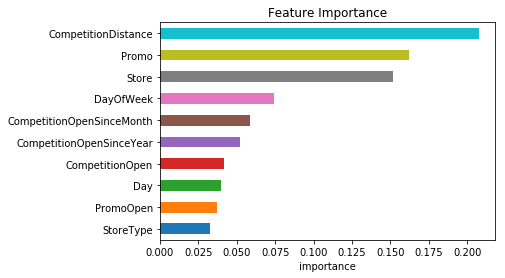

In [17]:
# plot feature importance for random forest model, show top 10 features
feat_importances = pd.Series(clf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(10).sort_values(ascending = True).plot(kind='barh')
plt.xlabel('importance')
plt.title('Feature Importance')

In [20]:
params = {"objective": "reg:linear", # 线性回归
          "booster" : "gbtree",   # 树模型
          "eta": 0.03,   # 学习率
          "max_depth": 10,    # 树最大深度
          "subsample": 0.9,    # 用于训练模型的子样本占整个样本集合的比例
          "colsample_bytree": 0.7,   # 在建立树时对特征采样的比例。缺省值为1
          "silent": 1,   # 取0时表示打印出运行时信息，取1时表示以默方式运行，不打印运行时信息。缺省值为0
          "seed": 10    }# 随机种子
num_boost_round = 4000

dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_valid, y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
# train the xgboost model
model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)

f:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:8.02086	eval-rmse:8.02743	train-rmspe:0.999808	eval-rmspe:0.999811
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78076	eval-rmse:7.78738	train-rmspe:0.99971	eval-rmspe:0.999714
[2]	train-rmse:7.54783	eval-rmse:7.55454	train-rmspe:0.99959	eval-rmspe:0.999595
[3]	train-rmse:7.32196	eval-rmse:7.32858	train-rmspe:0.999443	eval-rmspe:0.999449
[4]	train-rmse:7.10289	eval-rmse:7.10855	train-rmspe:0.999265	eval-rmspe:0.999272
[5]	train-rmse:6.89032	eval-rmse:6.89637	train-rmspe:0.999052	eval-rmspe:0.999062
[6]	train-rmse:6.68408	eval-rmse:6.69055	train-rmspe:0.998798	eval-rmspe:0.998811
[7]	train-rmse:6.48406	eval-rmse:6.49084	train-rmspe:0.998497	eval-rmspe:0.998514
[8]	train-rmse:6.29009	eval-rmse:6.29697	train-rmspe:0.998141	eval-rmspe:0.998162
[9]	train-rmse:6.10201	eval-rmse:6.10848	train-rmspe:0.997723	eval-rmspe:0.997748
[10]	train-rmse:5.91954	eval-rmse:5.

[97]	train-rmse:0.48789	eval-rmse:0.479653	train-rmspe:0.378429	eval-rmspe:0.361216
[98]	train-rmse:0.476916	eval-rmse:0.469063	train-rmspe:0.372438	eval-rmspe:0.354968
[99]	train-rmse:0.466409	eval-rmse:0.458758	train-rmspe:0.366732	eval-rmspe:0.348871
[100]	train-rmse:0.456321	eval-rmse:0.448909	train-rmspe:0.361246	eval-rmspe:0.343031
[101]	train-rmse:0.44645	eval-rmse:0.43944	train-rmspe:0.355872	eval-rmspe:0.337408
[102]	train-rmse:0.43709	eval-rmse:0.430126	train-rmspe:0.350813	eval-rmspe:0.33186
[103]	train-rmse:0.42771	eval-rmse:0.420646	train-rmspe:0.345723	eval-rmspe:0.326205
[104]	train-rmse:0.418572	eval-rmse:0.411751	train-rmspe:0.34083	eval-rmspe:0.320884
[105]	train-rmse:0.410265	eval-rmse:0.403622	train-rmspe:0.336369	eval-rmspe:0.316035
[106]	train-rmse:0.402242	eval-rmse:0.395998	train-rmspe:0.332067	eval-rmspe:0.311531
[107]	train-rmse:0.394261	eval-rmse:0.388093	train-rmspe:0.32788	eval-rmspe:0.306827
[108]	train-rmse:0.386366	eval-rmse:0.380341	train-rmspe:0.323679

[193]	train-rmse:0.196974	eval-rmse:0.205824	train-rmspe:0.243497	eval-rmspe:0.216887
[194]	train-rmse:0.196261	eval-rmse:0.205268	train-rmspe:0.243049	eval-rmspe:0.216509
[195]	train-rmse:0.195736	eval-rmse:0.204837	train-rmspe:0.242798	eval-rmspe:0.216197
[196]	train-rmse:0.195198	eval-rmse:0.204385	train-rmspe:0.242514	eval-rmspe:0.215851
[197]	train-rmse:0.194854	eval-rmse:0.204154	train-rmspe:0.242287	eval-rmspe:0.215846
[198]	train-rmse:0.19458	eval-rmse:0.204054	train-rmspe:0.242192	eval-rmspe:0.2159
[199]	train-rmse:0.194354	eval-rmse:0.203938	train-rmspe:0.242209	eval-rmspe:0.215919
[200]	train-rmse:0.194006	eval-rmse:0.203639	train-rmspe:0.2421	eval-rmspe:0.215764
[201]	train-rmse:0.193743	eval-rmse:0.203408	train-rmspe:0.241941	eval-rmspe:0.215662
[202]	train-rmse:0.193107	eval-rmse:0.202955	train-rmspe:0.241547	eval-rmspe:0.215398
[203]	train-rmse:0.192525	eval-rmse:0.202471	train-rmspe:0.241313	eval-rmspe:0.215082
[204]	train-rmse:0.192331	eval-rmse:0.202344	train-rmspe:0.

[289]	train-rmse:0.15983	eval-rmse:0.174687	train-rmspe:0.202283	eval-rmspe:0.189343
[290]	train-rmse:0.159325	eval-rmse:0.174195	train-rmspe:0.201842	eval-rmspe:0.188788
[291]	train-rmse:0.1591	eval-rmse:0.173993	train-rmspe:0.201531	eval-rmspe:0.188539
[292]	train-rmse:0.158929	eval-rmse:0.173905	train-rmspe:0.201074	eval-rmspe:0.188468
[293]	train-rmse:0.158816	eval-rmse:0.173871	train-rmspe:0.201019	eval-rmspe:0.188478
[294]	train-rmse:0.158391	eval-rmse:0.173465	train-rmspe:0.200666	eval-rmspe:0.188045
[295]	train-rmse:0.158184	eval-rmse:0.173313	train-rmspe:0.200486	eval-rmspe:0.187922
[296]	train-rmse:0.157951	eval-rmse:0.173101	train-rmspe:0.200145	eval-rmspe:0.187708
[297]	train-rmse:0.157743	eval-rmse:0.172936	train-rmspe:0.199934	eval-rmspe:0.187526
[298]	train-rmse:0.157032	eval-rmse:0.172336	train-rmspe:0.199246	eval-rmspe:0.18685
[299]	train-rmse:0.156782	eval-rmse:0.1721	train-rmspe:0.198962	eval-rmspe:0.186608
[300]	train-rmse:0.156659	eval-rmse:0.172001	train-rmspe:0.1

[385]	train-rmse:0.134544	eval-rmse:0.153606	train-rmspe:0.168704	eval-rmspe:0.166406
[386]	train-rmse:0.134453	eval-rmse:0.15357	train-rmspe:0.168626	eval-rmspe:0.166336
[387]	train-rmse:0.134322	eval-rmse:0.153435	train-rmspe:0.168476	eval-rmspe:0.166165
[388]	train-rmse:0.134247	eval-rmse:0.153379	train-rmspe:0.16832	eval-rmspe:0.166105
[389]	train-rmse:0.133966	eval-rmse:0.152924	train-rmspe:0.168072	eval-rmspe:0.165594
[390]	train-rmse:0.133624	eval-rmse:0.152637	train-rmspe:0.16775	eval-rmspe:0.165245
[391]	train-rmse:0.13332	eval-rmse:0.1524	train-rmspe:0.167413	eval-rmspe:0.164952
[392]	train-rmse:0.133011	eval-rmse:0.152148	train-rmspe:0.167088	eval-rmspe:0.164659
[393]	train-rmse:0.132645	eval-rmse:0.151856	train-rmspe:0.166761	eval-rmspe:0.164375
[394]	train-rmse:0.132391	eval-rmse:0.151622	train-rmspe:0.166536	eval-rmspe:0.164146
[395]	train-rmse:0.132131	eval-rmse:0.151258	train-rmspe:0.166327	eval-rmspe:0.163757
[396]	train-rmse:0.131894	eval-rmse:0.151042	train-rmspe:0.1

[481]	train-rmse:0.118977	eval-rmse:0.141065	train-rmspe:0.150976	eval-rmspe:0.152682
[482]	train-rmse:0.118912	eval-rmse:0.141015	train-rmspe:0.150919	eval-rmspe:0.152635
[483]	train-rmse:0.118853	eval-rmse:0.140993	train-rmspe:0.150674	eval-rmspe:0.152617
[484]	train-rmse:0.118793	eval-rmse:0.140933	train-rmspe:0.150602	eval-rmspe:0.152556
[485]	train-rmse:0.118715	eval-rmse:0.140867	train-rmspe:0.150616	eval-rmspe:0.152477
[486]	train-rmse:0.118584	eval-rmse:0.140746	train-rmspe:0.150496	eval-rmspe:0.152331
[487]	train-rmse:0.118482	eval-rmse:0.140654	train-rmspe:0.150406	eval-rmspe:0.152221
[488]	train-rmse:0.118345	eval-rmse:0.140537	train-rmspe:0.150275	eval-rmspe:0.152095
[489]	train-rmse:0.118303	eval-rmse:0.140492	train-rmspe:0.150249	eval-rmspe:0.15206
[490]	train-rmse:0.118237	eval-rmse:0.140439	train-rmspe:0.150192	eval-rmspe:0.152002
[491]	train-rmse:0.11815	eval-rmse:0.140372	train-rmspe:0.150111	eval-rmspe:0.151916
[492]	train-rmse:0.118001	eval-rmse:0.140256	train-rmspe

[577]	train-rmse:0.109993	eval-rmse:0.133401	train-rmspe:0.141476	eval-rmspe:0.144026
[578]	train-rmse:0.109935	eval-rmse:0.133374	train-rmspe:0.141414	eval-rmspe:0.143999
[579]	train-rmse:0.10989	eval-rmse:0.133354	train-rmspe:0.141407	eval-rmspe:0.143981
[580]	train-rmse:0.109843	eval-rmse:0.133321	train-rmspe:0.141348	eval-rmspe:0.143944
[581]	train-rmse:0.109807	eval-rmse:0.133297	train-rmspe:0.141297	eval-rmspe:0.143923
[582]	train-rmse:0.109706	eval-rmse:0.133219	train-rmspe:0.141203	eval-rmspe:0.143837
[583]	train-rmse:0.109683	eval-rmse:0.133208	train-rmspe:0.14117	eval-rmspe:0.143822
[584]	train-rmse:0.109616	eval-rmse:0.133267	train-rmspe:0.141095	eval-rmspe:0.143886
[585]	train-rmse:0.10957	eval-rmse:0.133232	train-rmspe:0.141057	eval-rmspe:0.143848
[586]	train-rmse:0.109513	eval-rmse:0.133221	train-rmspe:0.140888	eval-rmspe:0.143853
[587]	train-rmse:0.109393	eval-rmse:0.133119	train-rmspe:0.140781	eval-rmspe:0.14374
[588]	train-rmse:0.109328	eval-rmse:0.133086	train-rmspe:0

[673]	train-rmse:0.103934	eval-rmse:0.12879	train-rmspe:0.134407	eval-rmspe:0.138871
[674]	train-rmse:0.10382	eval-rmse:0.128783	train-rmspe:0.134287	eval-rmspe:0.138885
[675]	train-rmse:0.103775	eval-rmse:0.128742	train-rmspe:0.134236	eval-rmspe:0.138831
[676]	train-rmse:0.103754	eval-rmse:0.128725	train-rmspe:0.134202	eval-rmspe:0.138817
[677]	train-rmse:0.103671	eval-rmse:0.128667	train-rmspe:0.134093	eval-rmspe:0.138751
[678]	train-rmse:0.103649	eval-rmse:0.128649	train-rmspe:0.134071	eval-rmspe:0.138732
[679]	train-rmse:0.103619	eval-rmse:0.128645	train-rmspe:0.134044	eval-rmspe:0.138732
[680]	train-rmse:0.103584	eval-rmse:0.128618	train-rmspe:0.134013	eval-rmspe:0.1387
[681]	train-rmse:0.103535	eval-rmse:0.128575	train-rmspe:0.133969	eval-rmspe:0.138665
[682]	train-rmse:0.103484	eval-rmse:0.128529	train-rmspe:0.133923	eval-rmspe:0.138625
[683]	train-rmse:0.103396	eval-rmse:0.12846	train-rmspe:0.133848	eval-rmspe:0.13855
[684]	train-rmse:0.10336	eval-rmse:0.128435	train-rmspe:0.13

[769]	train-rmse:0.099034	eval-rmse:0.125739	train-rmspe:0.129151	eval-rmspe:0.13556
[770]	train-rmse:0.098977	eval-rmse:0.125701	train-rmspe:0.129094	eval-rmspe:0.135516
[771]	train-rmse:0.098918	eval-rmse:0.125662	train-rmspe:0.12904	eval-rmspe:0.135476
[772]	train-rmse:0.098841	eval-rmse:0.125613	train-rmspe:0.128945	eval-rmspe:0.135421
[773]	train-rmse:0.098808	eval-rmse:0.12559	train-rmspe:0.128917	eval-rmspe:0.135393
[774]	train-rmse:0.09876	eval-rmse:0.125559	train-rmspe:0.128875	eval-rmspe:0.135362
[775]	train-rmse:0.098686	eval-rmse:0.125523	train-rmspe:0.128792	eval-rmspe:0.135329
[776]	train-rmse:0.098658	eval-rmse:0.125501	train-rmspe:0.128765	eval-rmspe:0.135305
[777]	train-rmse:0.09863	eval-rmse:0.125488	train-rmspe:0.128735	eval-rmspe:0.135287
[778]	train-rmse:0.098615	eval-rmse:0.125486	train-rmspe:0.128726	eval-rmspe:0.135287
[779]	train-rmse:0.098582	eval-rmse:0.125469	train-rmspe:0.128679	eval-rmspe:0.13527
[780]	train-rmse:0.098565	eval-rmse:0.125477	train-rmspe:0.1

[865]	train-rmse:0.0957	eval-rmse:0.123838	train-rmspe:0.125336	eval-rmspe:0.133505
[866]	train-rmse:0.09567	eval-rmse:0.123847	train-rmspe:0.125305	eval-rmspe:0.133522
[867]	train-rmse:0.095645	eval-rmse:0.123825	train-rmspe:0.125275	eval-rmspe:0.133491
[868]	train-rmse:0.095638	eval-rmse:0.123825	train-rmspe:0.125269	eval-rmspe:0.13349
[869]	train-rmse:0.095594	eval-rmse:0.123797	train-rmspe:0.12523	eval-rmspe:0.13346
[870]	train-rmse:0.095568	eval-rmse:0.123787	train-rmspe:0.125207	eval-rmspe:0.133448
[871]	train-rmse:0.095546	eval-rmse:0.123776	train-rmspe:0.125184	eval-rmspe:0.133435
[872]	train-rmse:0.095507	eval-rmse:0.123782	train-rmspe:0.125136	eval-rmspe:0.133454
[873]	train-rmse:0.095479	eval-rmse:0.123776	train-rmspe:0.125115	eval-rmspe:0.13345
[874]	train-rmse:0.095453	eval-rmse:0.123767	train-rmspe:0.125089	eval-rmspe:0.133439
[875]	train-rmse:0.095387	eval-rmse:0.123717	train-rmspe:0.125026	eval-rmspe:0.133384
[876]	train-rmse:0.095371	eval-rmse:0.123707	train-rmspe:0.12

[961]	train-rmse:0.092723	eval-rmse:0.122459	train-rmspe:0.119669	eval-rmspe:0.131935
[962]	train-rmse:0.09269	eval-rmse:0.122457	train-rmspe:0.119635	eval-rmspe:0.131932
[963]	train-rmse:0.092671	eval-rmse:0.122447	train-rmspe:0.119617	eval-rmspe:0.131921
[964]	train-rmse:0.092652	eval-rmse:0.122451	train-rmspe:0.119582	eval-rmspe:0.13193
[965]	train-rmse:0.09262	eval-rmse:0.122432	train-rmspe:0.11955	eval-rmspe:0.131912
[966]	train-rmse:0.092599	eval-rmse:0.12242	train-rmspe:0.119542	eval-rmspe:0.131898
[967]	train-rmse:0.09258	eval-rmse:0.122426	train-rmspe:0.119506	eval-rmspe:0.13191
[968]	train-rmse:0.092573	eval-rmse:0.122411	train-rmspe:0.1195	eval-rmspe:0.131894
[969]	train-rmse:0.092569	eval-rmse:0.122407	train-rmspe:0.119496	eval-rmspe:0.131889
[970]	train-rmse:0.092538	eval-rmse:0.122387	train-rmspe:0.119374	eval-rmspe:0.131869
[971]	train-rmse:0.092508	eval-rmse:0.122373	train-rmspe:0.11933	eval-rmspe:0.131855
[972]	train-rmse:0.092461	eval-rmse:0.12235	train-rmspe:0.119288

[1057]	train-rmse:0.090052	eval-rmse:0.121199	train-rmspe:0.114012	eval-rmspe:0.130483
[1058]	train-rmse:0.090029	eval-rmse:0.121187	train-rmspe:0.113991	eval-rmspe:0.130467
[1059]	train-rmse:0.090001	eval-rmse:0.121106	train-rmspe:0.113947	eval-rmspe:0.13036
[1060]	train-rmse:0.089966	eval-rmse:0.121086	train-rmspe:0.113914	eval-rmspe:0.130339
[1061]	train-rmse:0.089927	eval-rmse:0.121082	train-rmspe:0.11383	eval-rmspe:0.130339
[1062]	train-rmse:0.089924	eval-rmse:0.121082	train-rmspe:0.113827	eval-rmspe:0.130339
[1063]	train-rmse:0.0899	eval-rmse:0.121064	train-rmspe:0.113814	eval-rmspe:0.130318
[1064]	train-rmse:0.089861	eval-rmse:0.12106	train-rmspe:0.113778	eval-rmspe:0.130314
[1065]	train-rmse:0.089842	eval-rmse:0.121065	train-rmspe:0.11375	eval-rmspe:0.130317
[1066]	train-rmse:0.089808	eval-rmse:0.121044	train-rmspe:0.113715	eval-rmspe:0.130294
[1067]	train-rmse:0.089777	eval-rmse:0.121006	train-rmspe:0.11369	eval-rmspe:0.130208
[1068]	train-rmse:0.089757	eval-rmse:0.120995	trai

[1152]	train-rmse:0.08774	eval-rmse:0.120065	train-rmspe:0.111527	eval-rmspe:0.129166
[1153]	train-rmse:0.08772	eval-rmse:0.120063	train-rmspe:0.111503	eval-rmspe:0.129162
[1154]	train-rmse:0.087699	eval-rmse:0.120054	train-rmspe:0.111481	eval-rmspe:0.129151
[1155]	train-rmse:0.087677	eval-rmse:0.120044	train-rmspe:0.111457	eval-rmspe:0.129142
[1156]	train-rmse:0.087656	eval-rmse:0.120039	train-rmspe:0.111429	eval-rmspe:0.129137
[1157]	train-rmse:0.087632	eval-rmse:0.120029	train-rmspe:0.111408	eval-rmspe:0.129127
[1158]	train-rmse:0.087614	eval-rmse:0.120023	train-rmspe:0.111388	eval-rmspe:0.12912
[1159]	train-rmse:0.087611	eval-rmse:0.120022	train-rmspe:0.111387	eval-rmspe:0.129118
[1160]	train-rmse:0.087596	eval-rmse:0.120012	train-rmspe:0.111372	eval-rmspe:0.129107
[1161]	train-rmse:0.087577	eval-rmse:0.120004	train-rmspe:0.11135	eval-rmspe:0.129098
[1162]	train-rmse:0.087553	eval-rmse:0.120012	train-rmspe:0.111321	eval-rmspe:0.129114
[1163]	train-rmse:0.087537	eval-rmse:0.120013	t

[1247]	train-rmse:0.085851	eval-rmse:0.119488	train-rmspe:0.106017	eval-rmspe:0.128628
[1248]	train-rmse:0.085838	eval-rmse:0.119483	train-rmspe:0.106002	eval-rmspe:0.128622
[1249]	train-rmse:0.085808	eval-rmse:0.119486	train-rmspe:0.105971	eval-rmspe:0.128627
[1250]	train-rmse:0.085784	eval-rmse:0.119496	train-rmspe:0.105946	eval-rmspe:0.128639
[1251]	train-rmse:0.085776	eval-rmse:0.119506	train-rmspe:0.105933	eval-rmspe:0.128651
[1252]	train-rmse:0.085761	eval-rmse:0.119501	train-rmspe:0.105918	eval-rmspe:0.128647
[1253]	train-rmse:0.085743	eval-rmse:0.11949	train-rmspe:0.105899	eval-rmspe:0.128631
[1254]	train-rmse:0.085708	eval-rmse:0.119515	train-rmspe:0.105857	eval-rmspe:0.128666
[1255]	train-rmse:0.085684	eval-rmse:0.11946	train-rmspe:0.105773	eval-rmspe:0.128583
[1256]	train-rmse:0.085664	eval-rmse:0.119461	train-rmspe:0.105748	eval-rmspe:0.128581
[1257]	train-rmse:0.085637	eval-rmse:0.119457	train-rmspe:0.105708	eval-rmspe:0.128565
[1258]	train-rmse:0.085619	eval-rmse:0.119449

[1342]	train-rmse:0.084153	eval-rmse:0.119006	train-rmspe:0.102876	eval-rmspe:0.128093
[1343]	train-rmse:0.08414	eval-rmse:0.119001	train-rmspe:0.102861	eval-rmspe:0.128087
[1344]	train-rmse:0.084125	eval-rmse:0.119	train-rmspe:0.10224	eval-rmspe:0.128086
[1345]	train-rmse:0.08411	eval-rmse:0.118995	train-rmspe:0.10222	eval-rmspe:0.128081
[1346]	train-rmse:0.0841	eval-rmse:0.118997	train-rmspe:0.102211	eval-rmspe:0.12808
[1347]	train-rmse:0.084084	eval-rmse:0.11902	train-rmspe:0.102184	eval-rmspe:0.128114
[1348]	train-rmse:0.084071	eval-rmse:0.11902	train-rmspe:0.102169	eval-rmspe:0.128113
[1349]	train-rmse:0.084054	eval-rmse:0.119022	train-rmspe:0.102155	eval-rmspe:0.128118
[1350]	train-rmse:0.084038	eval-rmse:0.119019	train-rmspe:0.10214	eval-rmspe:0.128118
[1351]	train-rmse:0.084013	eval-rmse:0.119007	train-rmspe:0.102118	eval-rmspe:0.128104
[1352]	train-rmse:0.084003	eval-rmse:0.119002	train-rmspe:0.101854	eval-rmspe:0.128099
[1353]	train-rmse:0.083987	eval-rmse:0.118998	train-rmsp

[1437]	train-rmse:0.082543	eval-rmse:0.118607	train-rmspe:0.098659	eval-rmspe:0.127659
[1438]	train-rmse:0.082531	eval-rmse:0.1186	train-rmspe:0.098637	eval-rmspe:0.127651
[1439]	train-rmse:0.082525	eval-rmse:0.118597	train-rmspe:0.098629	eval-rmspe:0.127646
[1440]	train-rmse:0.082501	eval-rmse:0.118585	train-rmspe:0.098606	eval-rmspe:0.127634
[1441]	train-rmse:0.082481	eval-rmse:0.118579	train-rmspe:0.098586	eval-rmspe:0.127628
[1442]	train-rmse:0.08247	eval-rmse:0.118576	train-rmspe:0.098576	eval-rmspe:0.127623
[1443]	train-rmse:0.082447	eval-rmse:0.118565	train-rmspe:0.098551	eval-rmspe:0.127612
[1444]	train-rmse:0.082434	eval-rmse:0.118572	train-rmspe:0.098539	eval-rmspe:0.127621
[1445]	train-rmse:0.082417	eval-rmse:0.118564	train-rmspe:0.098523	eval-rmspe:0.127613
[1446]	train-rmse:0.082395	eval-rmse:0.118552	train-rmspe:0.098498	eval-rmspe:0.127599
[1447]	train-rmse:0.082375	eval-rmse:0.118553	train-rmspe:0.09847	eval-rmspe:0.127601
[1448]	train-rmse:0.082353	eval-rmse:0.118536	t

[1532]	train-rmse:0.081085	eval-rmse:0.118375	train-rmspe:0.095136	eval-rmspe:0.127429
[1533]	train-rmse:0.081075	eval-rmse:0.118368	train-rmspe:0.095122	eval-rmspe:0.127423
[1534]	train-rmse:0.08107	eval-rmse:0.118368	train-rmspe:0.095118	eval-rmspe:0.127423
[1535]	train-rmse:0.081057	eval-rmse:0.11837	train-rmspe:0.095103	eval-rmspe:0.12743
[1536]	train-rmse:0.081039	eval-rmse:0.118369	train-rmspe:0.095066	eval-rmspe:0.12743
[1537]	train-rmse:0.081024	eval-rmse:0.118364	train-rmspe:0.095046	eval-rmspe:0.127421
[1538]	train-rmse:0.081014	eval-rmse:0.118358	train-rmspe:0.095028	eval-rmspe:0.127416
[1539]	train-rmse:0.081003	eval-rmse:0.118351	train-rmspe:0.095016	eval-rmspe:0.127408
[1540]	train-rmse:0.080988	eval-rmse:0.118351	train-rmspe:0.094999	eval-rmspe:0.127407
[1541]	train-rmse:0.080973	eval-rmse:0.118351	train-rmspe:0.094985	eval-rmspe:0.127405
[1542]	train-rmse:0.080964	eval-rmse:0.118352	train-rmspe:0.094974	eval-rmspe:0.127408
[1543]	train-rmse:0.080955	eval-rmse:0.118348	t

[1627]	train-rmse:0.079736	eval-rmse:0.117974	train-rmspe:0.092584	eval-rmspe:0.126976
[1628]	train-rmse:0.079717	eval-rmse:0.117969	train-rmspe:0.092565	eval-rmspe:0.126972
[1629]	train-rmse:0.079699	eval-rmse:0.117964	train-rmspe:0.092542	eval-rmspe:0.126969
[1630]	train-rmse:0.079685	eval-rmse:0.117961	train-rmspe:0.09252	eval-rmspe:0.126964
[1631]	train-rmse:0.079672	eval-rmse:0.11796	train-rmspe:0.092495	eval-rmspe:0.126964
[1632]	train-rmse:0.079648	eval-rmse:0.117949	train-rmspe:0.092466	eval-rmspe:0.126953
[1633]	train-rmse:0.079637	eval-rmse:0.117949	train-rmspe:0.092452	eval-rmspe:0.126952
[1634]	train-rmse:0.079611	eval-rmse:0.117936	train-rmspe:0.092427	eval-rmspe:0.126938
[1635]	train-rmse:0.0796	eval-rmse:0.117933	train-rmspe:0.092414	eval-rmspe:0.126935
[1636]	train-rmse:0.079591	eval-rmse:0.117925	train-rmspe:0.092405	eval-rmspe:0.12692
[1637]	train-rmse:0.07958	eval-rmse:0.117917	train-rmspe:0.092392	eval-rmspe:0.126912
[1638]	train-rmse:0.079569	eval-rmse:0.11791	trai

[1722]	train-rmse:0.078486	eval-rmse:0.117692	train-rmspe:0.090349	eval-rmspe:0.126641
[1723]	train-rmse:0.078478	eval-rmse:0.117688	train-rmspe:0.090341	eval-rmspe:0.126636
[1724]	train-rmse:0.078465	eval-rmse:0.117685	train-rmspe:0.090329	eval-rmspe:0.126632
[1725]	train-rmse:0.078457	eval-rmse:0.11768	train-rmspe:0.09032	eval-rmspe:0.126627
[1726]	train-rmse:0.078447	eval-rmse:0.117678	train-rmspe:0.090311	eval-rmspe:0.126626
[1727]	train-rmse:0.078429	eval-rmse:0.117674	train-rmspe:0.090291	eval-rmspe:0.126623
[1728]	train-rmse:0.078424	eval-rmse:0.117671	train-rmspe:0.090185	eval-rmspe:0.126621
[1729]	train-rmse:0.07841	eval-rmse:0.117668	train-rmspe:0.090159	eval-rmspe:0.126615
[1730]	train-rmse:0.078399	eval-rmse:0.117671	train-rmspe:0.09012	eval-rmspe:0.126616
[1731]	train-rmse:0.078386	eval-rmse:0.117665	train-rmspe:0.090105	eval-rmspe:0.126609
[1732]	train-rmse:0.078375	eval-rmse:0.117662	train-rmspe:0.090084	eval-rmspe:0.126606
[1733]	train-rmse:0.078359	eval-rmse:0.117656	t

[1817]	train-rmse:0.077337	eval-rmse:0.117428	train-rmspe:0.088525	eval-rmspe:0.126397
[1818]	train-rmse:0.077323	eval-rmse:0.117425	train-rmspe:0.088504	eval-rmspe:0.126394
[1819]	train-rmse:0.077312	eval-rmse:0.117423	train-rmspe:0.088492	eval-rmspe:0.126391
[1820]	train-rmse:0.077301	eval-rmse:0.117422	train-rmspe:0.088481	eval-rmspe:0.126389
[1821]	train-rmse:0.077287	eval-rmse:0.11742	train-rmspe:0.088466	eval-rmspe:0.126388
[1822]	train-rmse:0.077274	eval-rmse:0.117417	train-rmspe:0.088431	eval-rmspe:0.126386
[1823]	train-rmse:0.077265	eval-rmse:0.117414	train-rmspe:0.08842	eval-rmspe:0.126383
[1824]	train-rmse:0.077256	eval-rmse:0.117412	train-rmspe:0.088411	eval-rmspe:0.126381
[1825]	train-rmse:0.07725	eval-rmse:0.117408	train-rmspe:0.088401	eval-rmspe:0.126376
[1826]	train-rmse:0.077238	eval-rmse:0.117397	train-rmspe:0.08839	eval-rmspe:0.126357
[1827]	train-rmse:0.077229	eval-rmse:0.117395	train-rmspe:0.08838	eval-rmspe:0.126355
[1828]	train-rmse:0.077217	eval-rmse:0.117393	tr

[1912]	train-rmse:0.076225	eval-rmse:0.117227	train-rmspe:0.086156	eval-rmspe:0.126211
[1913]	train-rmse:0.076209	eval-rmse:0.11723	train-rmspe:0.086136	eval-rmspe:0.126211
[1914]	train-rmse:0.076199	eval-rmse:0.117228	train-rmspe:0.086126	eval-rmspe:0.126208
[1915]	train-rmse:0.076173	eval-rmse:0.117216	train-rmspe:0.086098	eval-rmspe:0.126199
[1916]	train-rmse:0.076165	eval-rmse:0.117212	train-rmspe:0.086089	eval-rmspe:0.126196
[1917]	train-rmse:0.076152	eval-rmse:0.117212	train-rmspe:0.086045	eval-rmspe:0.126197
[1918]	train-rmse:0.076143	eval-rmse:0.11721	train-rmspe:0.086032	eval-rmspe:0.126194
[1919]	train-rmse:0.076136	eval-rmse:0.117207	train-rmspe:0.086027	eval-rmspe:0.126191
[1920]	train-rmse:0.076121	eval-rmse:0.117202	train-rmspe:0.085976	eval-rmspe:0.126186
[1921]	train-rmse:0.076108	eval-rmse:0.117197	train-rmspe:0.085961	eval-rmspe:0.126182
[1922]	train-rmse:0.076097	eval-rmse:0.117198	train-rmspe:0.08595	eval-rmspe:0.126183
[1923]	train-rmse:0.076087	eval-rmse:0.117193	

[2007]	train-rmse:0.075207	eval-rmse:0.117033	train-rmspe:0.084093	eval-rmspe:0.126034
[2008]	train-rmse:0.075187	eval-rmse:0.117023	train-rmspe:0.08407	eval-rmspe:0.126024
[2009]	train-rmse:0.075178	eval-rmse:0.117018	train-rmspe:0.08406	eval-rmspe:0.126015
[2010]	train-rmse:0.075167	eval-rmse:0.117017	train-rmspe:0.084048	eval-rmspe:0.126014
[2011]	train-rmse:0.075158	eval-rmse:0.117017	train-rmspe:0.084046	eval-rmspe:0.126014
[2012]	train-rmse:0.075151	eval-rmse:0.117013	train-rmspe:0.084038	eval-rmspe:0.126007
[2013]	train-rmse:0.075144	eval-rmse:0.117011	train-rmspe:0.084031	eval-rmspe:0.126005
[2014]	train-rmse:0.075136	eval-rmse:0.117011	train-rmspe:0.084021	eval-rmspe:0.126005
[2015]	train-rmse:0.075128	eval-rmse:0.11701	train-rmspe:0.084013	eval-rmspe:0.126003
[2016]	train-rmse:0.075118	eval-rmse:0.117009	train-rmspe:0.084	eval-rmspe:0.126002
[2017]	train-rmse:0.075108	eval-rmse:0.117009	train-rmspe:0.083983	eval-rmspe:0.126001
[2018]	train-rmse:0.075095	eval-rmse:0.117006	tra

[2102]	train-rmse:0.074248	eval-rmse:0.116862	train-rmspe:0.082755	eval-rmspe:0.125816
[2103]	train-rmse:0.074237	eval-rmse:0.116867	train-rmspe:0.082742	eval-rmspe:0.125821
[2104]	train-rmse:0.074224	eval-rmse:0.116861	train-rmspe:0.082724	eval-rmspe:0.125814
[2105]	train-rmse:0.07421	eval-rmse:0.116855	train-rmspe:0.082707	eval-rmspe:0.125808
[2106]	train-rmse:0.074199	eval-rmse:0.116862	train-rmspe:0.082693	eval-rmspe:0.125814
[2107]	train-rmse:0.074191	eval-rmse:0.116859	train-rmspe:0.082686	eval-rmspe:0.12581
[2108]	train-rmse:0.074183	eval-rmse:0.116855	train-rmspe:0.082677	eval-rmspe:0.125809
[2109]	train-rmse:0.074175	eval-rmse:0.116856	train-rmspe:0.082668	eval-rmspe:0.125808
[2110]	train-rmse:0.074164	eval-rmse:0.116855	train-rmspe:0.082655	eval-rmspe:0.125808
[2111]	train-rmse:0.07416	eval-rmse:0.116856	train-rmspe:0.082651	eval-rmspe:0.12581
[2112]	train-rmse:0.074148	eval-rmse:0.116858	train-rmspe:0.082631	eval-rmspe:0.125813
[2113]	train-rmse:0.074135	eval-rmse:0.116856	t

[2197]	train-rmse:0.073353	eval-rmse:0.11675	train-rmspe:0.08098	eval-rmspe:0.125699
[2198]	train-rmse:0.073348	eval-rmse:0.11675	train-rmspe:0.080973	eval-rmspe:0.125699
[2199]	train-rmse:0.073344	eval-rmse:0.116748	train-rmspe:0.080969	eval-rmspe:0.125697
[2200]	train-rmse:0.073335	eval-rmse:0.116746	train-rmspe:0.080954	eval-rmspe:0.125695
[2201]	train-rmse:0.073327	eval-rmse:0.116746	train-rmspe:0.080939	eval-rmspe:0.125695
[2202]	train-rmse:0.073322	eval-rmse:0.116745	train-rmspe:0.080933	eval-rmspe:0.125693
[2203]	train-rmse:0.073312	eval-rmse:0.116746	train-rmspe:0.080922	eval-rmspe:0.125696
[2204]	train-rmse:0.0733	eval-rmse:0.116743	train-rmspe:0.080854	eval-rmspe:0.125693
[2205]	train-rmse:0.073292	eval-rmse:0.116739	train-rmspe:0.080847	eval-rmspe:0.125687
[2206]	train-rmse:0.073286	eval-rmse:0.116738	train-rmspe:0.080841	eval-rmspe:0.125685
[2207]	train-rmse:0.073277	eval-rmse:0.116736	train-rmspe:0.080789	eval-rmspe:0.125684
[2208]	train-rmse:0.073272	eval-rmse:0.116733	tr

[2292]	train-rmse:0.07251	eval-rmse:0.11668	train-rmspe:0.079715	eval-rmspe:0.125651
[2293]	train-rmse:0.072503	eval-rmse:0.116681	train-rmspe:0.079706	eval-rmspe:0.125653
[2294]	train-rmse:0.072499	eval-rmse:0.116681	train-rmspe:0.079702	eval-rmspe:0.125654
[2295]	train-rmse:0.072493	eval-rmse:0.116679	train-rmspe:0.079691	eval-rmspe:0.125653
[2296]	train-rmse:0.072484	eval-rmse:0.116677	train-rmspe:0.079682	eval-rmspe:0.125651
[2297]	train-rmse:0.072475	eval-rmse:0.116677	train-rmspe:0.079671	eval-rmspe:0.125651
[2298]	train-rmse:0.07247	eval-rmse:0.116675	train-rmspe:0.079666	eval-rmspe:0.125649
[2299]	train-rmse:0.072464	eval-rmse:0.116673	train-rmspe:0.07966	eval-rmspe:0.125648
[2300]	train-rmse:0.072452	eval-rmse:0.116671	train-rmspe:0.079644	eval-rmspe:0.125644
[2301]	train-rmse:0.072441	eval-rmse:0.116668	train-rmspe:0.07963	eval-rmspe:0.125643
[2302]	train-rmse:0.072432	eval-rmse:0.116667	train-rmspe:0.079615	eval-rmspe:0.125638
[2303]	train-rmse:0.072424	eval-rmse:0.116658	tr

[2387]	train-rmse:0.071727	eval-rmse:0.116633	train-rmspe:0.078441	eval-rmspe:0.125619
[2388]	train-rmse:0.071718	eval-rmse:0.116648	train-rmspe:0.078431	eval-rmspe:0.12564
[2389]	train-rmse:0.071707	eval-rmse:0.116643	train-rmspe:0.078388	eval-rmspe:0.125634
[2390]	train-rmse:0.071697	eval-rmse:0.116644	train-rmspe:0.078377	eval-rmspe:0.125636
[2391]	train-rmse:0.071686	eval-rmse:0.11664	train-rmspe:0.078364	eval-rmspe:0.125633
[2392]	train-rmse:0.071672	eval-rmse:0.116635	train-rmspe:0.078348	eval-rmspe:0.125627
[2393]	train-rmse:0.071665	eval-rmse:0.116631	train-rmspe:0.07834	eval-rmspe:0.125622
[2394]	train-rmse:0.071659	eval-rmse:0.11663	train-rmspe:0.078334	eval-rmspe:0.12562
[2395]	train-rmse:0.071652	eval-rmse:0.116629	train-rmspe:0.078325	eval-rmspe:0.125618
[2396]	train-rmse:0.071647	eval-rmse:0.11663	train-rmspe:0.07832	eval-rmspe:0.125619
[2397]	train-rmse:0.071636	eval-rmse:0.116626	train-rmspe:0.078302	eval-rmspe:0.125615
[2398]	train-rmse:0.071629	eval-rmse:0.116624	trai

[2482]	train-rmse:0.070898	eval-rmse:0.11657	train-rmspe:0.077084	eval-rmspe:0.125552
[2483]	train-rmse:0.07089	eval-rmse:0.116568	train-rmspe:0.077077	eval-rmspe:0.12555
[2484]	train-rmse:0.070881	eval-rmse:0.116566	train-rmspe:0.077066	eval-rmspe:0.125548
[2485]	train-rmse:0.070867	eval-rmse:0.116566	train-rmspe:0.077045	eval-rmspe:0.125549
[2486]	train-rmse:0.070865	eval-rmse:0.116566	train-rmspe:0.077041	eval-rmspe:0.125549
[2487]	train-rmse:0.07086	eval-rmse:0.116562	train-rmspe:0.077032	eval-rmspe:0.125545
[2488]	train-rmse:0.070849	eval-rmse:0.116586	train-rmspe:0.076967	eval-rmspe:0.125565
[2489]	train-rmse:0.07084	eval-rmse:0.116594	train-rmspe:0.076958	eval-rmspe:0.125574
[2490]	train-rmse:0.070832	eval-rmse:0.116591	train-rmspe:0.076949	eval-rmspe:0.125572
[2491]	train-rmse:0.070822	eval-rmse:0.11659	train-rmspe:0.076935	eval-rmspe:0.125572
[2492]	train-rmse:0.070811	eval-rmse:0.116589	train-rmspe:0.076923	eval-rmspe:0.12557
[2493]	train-rmse:0.070798	eval-rmse:0.116589	trai

[2577]	train-rmse:0.07011	eval-rmse:0.116509	train-rmspe:0.07597	eval-rmspe:0.125503
[2578]	train-rmse:0.070102	eval-rmse:0.116509	train-rmspe:0.075958	eval-rmspe:0.125504
[2579]	train-rmse:0.070096	eval-rmse:0.116509	train-rmspe:0.075951	eval-rmspe:0.125504
[2580]	train-rmse:0.070087	eval-rmse:0.116508	train-rmspe:0.075936	eval-rmspe:0.125503
[2581]	train-rmse:0.070079	eval-rmse:0.116515	train-rmspe:0.075928	eval-rmspe:0.125511
[2582]	train-rmse:0.070067	eval-rmse:0.116509	train-rmspe:0.075916	eval-rmspe:0.125505
[2583]	train-rmse:0.070059	eval-rmse:0.116515	train-rmspe:0.075907	eval-rmspe:0.125509
[2584]	train-rmse:0.07005	eval-rmse:0.116513	train-rmspe:0.075894	eval-rmspe:0.125507
[2585]	train-rmse:0.070036	eval-rmse:0.11651	train-rmspe:0.075876	eval-rmspe:0.125503
[2586]	train-rmse:0.070028	eval-rmse:0.116511	train-rmspe:0.075867	eval-rmspe:0.125505
[2587]	train-rmse:0.07002	eval-rmse:0.116511	train-rmspe:0.075853	eval-rmspe:0.125505
[2588]	train-rmse:0.070011	eval-rmse:0.116512	tr

[2672]	train-rmse:0.069369	eval-rmse:0.116429	train-rmspe:0.074843	eval-rmspe:0.125401
[2673]	train-rmse:0.069354	eval-rmse:0.11643	train-rmspe:0.074811	eval-rmspe:0.125403
[2674]	train-rmse:0.069346	eval-rmse:0.116429	train-rmspe:0.074802	eval-rmspe:0.125401
[2675]	train-rmse:0.069341	eval-rmse:0.116431	train-rmspe:0.074797	eval-rmspe:0.1254
[2676]	train-rmse:0.069336	eval-rmse:0.116429	train-rmspe:0.074789	eval-rmspe:0.125398
[2677]	train-rmse:0.069333	eval-rmse:0.116428	train-rmspe:0.074786	eval-rmspe:0.125396
[2678]	train-rmse:0.069324	eval-rmse:0.116433	train-rmspe:0.074776	eval-rmspe:0.125401
[2679]	train-rmse:0.06932	eval-rmse:0.116436	train-rmspe:0.074772	eval-rmspe:0.125405
[2680]	train-rmse:0.069317	eval-rmse:0.116435	train-rmspe:0.074768	eval-rmspe:0.125405
[2681]	train-rmse:0.069309	eval-rmse:0.116434	train-rmspe:0.074759	eval-rmspe:0.125405
[2682]	train-rmse:0.069303	eval-rmse:0.116434	train-rmspe:0.074753	eval-rmspe:0.125405
[2683]	train-rmse:0.069295	eval-rmse:0.116434	t

[2767]	train-rmse:0.068665	eval-rmse:0.11636	train-rmspe:0.073875	eval-rmspe:0.125309
[2768]	train-rmse:0.068656	eval-rmse:0.116346	train-rmspe:0.073865	eval-rmspe:0.125283
[2769]	train-rmse:0.068649	eval-rmse:0.116349	train-rmspe:0.073855	eval-rmspe:0.125287
[2770]	train-rmse:0.068639	eval-rmse:0.116348	train-rmspe:0.073843	eval-rmspe:0.125286
[2771]	train-rmse:0.068632	eval-rmse:0.116345	train-rmspe:0.073834	eval-rmspe:0.125284
[2772]	train-rmse:0.068625	eval-rmse:0.116346	train-rmspe:0.073825	eval-rmspe:0.125284
[2773]	train-rmse:0.068621	eval-rmse:0.116346	train-rmspe:0.073821	eval-rmspe:0.125285
[2774]	train-rmse:0.068613	eval-rmse:0.116345	train-rmspe:0.073813	eval-rmspe:0.125284
[2775]	train-rmse:0.068608	eval-rmse:0.116344	train-rmspe:0.073806	eval-rmspe:0.125282
[2776]	train-rmse:0.0686	eval-rmse:0.116346	train-rmspe:0.073795	eval-rmspe:0.125283
[2777]	train-rmse:0.068589	eval-rmse:0.116345	train-rmspe:0.073782	eval-rmspe:0.12528
[2778]	train-rmse:0.068583	eval-rmse:0.116344	t

[2862]	train-rmse:0.067965	eval-rmse:0.116337	train-rmspe:0.072739	eval-rmspe:0.125285
[2863]	train-rmse:0.067951	eval-rmse:0.116336	train-rmspe:0.072716	eval-rmspe:0.125283
[2864]	train-rmse:0.067943	eval-rmse:0.116331	train-rmspe:0.072707	eval-rmspe:0.125275
[2865]	train-rmse:0.067938	eval-rmse:0.116332	train-rmspe:0.072701	eval-rmspe:0.125276
[2866]	train-rmse:0.067934	eval-rmse:0.116332	train-rmspe:0.072696	eval-rmspe:0.125277
[2867]	train-rmse:0.067925	eval-rmse:0.116333	train-rmspe:0.072684	eval-rmspe:0.125278
[2868]	train-rmse:0.067919	eval-rmse:0.116333	train-rmspe:0.072676	eval-rmspe:0.125278
[2869]	train-rmse:0.067909	eval-rmse:0.11633	train-rmspe:0.072635	eval-rmspe:0.125275
[2870]	train-rmse:0.067903	eval-rmse:0.11633	train-rmspe:0.072627	eval-rmspe:0.125275
[2871]	train-rmse:0.067894	eval-rmse:0.116329	train-rmspe:0.072618	eval-rmspe:0.125273
[2872]	train-rmse:0.067888	eval-rmse:0.116331	train-rmspe:0.072609	eval-rmspe:0.125275
[2873]	train-rmse:0.067882	eval-rmse:0.11633	

[2957]	train-rmse:0.067304	eval-rmse:0.116289	train-rmspe:0.071819	eval-rmspe:0.125212
[2958]	train-rmse:0.067295	eval-rmse:0.116288	train-rmspe:0.071803	eval-rmspe:0.125213
[2959]	train-rmse:0.06729	eval-rmse:0.116288	train-rmspe:0.071798	eval-rmspe:0.125212
[2960]	train-rmse:0.067281	eval-rmse:0.116288	train-rmspe:0.071788	eval-rmspe:0.125212
[2961]	train-rmse:0.067276	eval-rmse:0.116289	train-rmspe:0.071782	eval-rmspe:0.125213
[2962]	train-rmse:0.067272	eval-rmse:0.116288	train-rmspe:0.071777	eval-rmspe:0.125214
[2963]	train-rmse:0.067266	eval-rmse:0.11629	train-rmspe:0.07177	eval-rmspe:0.125218
[2964]	train-rmse:0.067258	eval-rmse:0.116287	train-rmspe:0.071749	eval-rmspe:0.125216
[2965]	train-rmse:0.067251	eval-rmse:0.116288	train-rmspe:0.071741	eval-rmspe:0.125216
[2966]	train-rmse:0.067244	eval-rmse:0.11629	train-rmspe:0.071735	eval-rmspe:0.125217
[2967]	train-rmse:0.067239	eval-rmse:0.116289	train-rmspe:0.071728	eval-rmspe:0.125216
[2968]	train-rmse:0.06723	eval-rmse:0.116288	tr

[3052]	train-rmse:0.066661	eval-rmse:0.116272	train-rmspe:0.070928	eval-rmspe:0.125197
[3053]	train-rmse:0.066655	eval-rmse:0.116269	train-rmspe:0.070921	eval-rmspe:0.125195
[3054]	train-rmse:0.066649	eval-rmse:0.116268	train-rmspe:0.070915	eval-rmspe:0.125196
[3055]	train-rmse:0.066643	eval-rmse:0.11627	train-rmspe:0.070908	eval-rmspe:0.125197
[3056]	train-rmse:0.066638	eval-rmse:0.116268	train-rmspe:0.0709	eval-rmspe:0.125194
[3057]	train-rmse:0.066632	eval-rmse:0.116268	train-rmspe:0.070893	eval-rmspe:0.125194
[3058]	train-rmse:0.066626	eval-rmse:0.116265	train-rmspe:0.070887	eval-rmspe:0.125192
[3059]	train-rmse:0.066619	eval-rmse:0.116251	train-rmspe:0.07088	eval-rmspe:0.125168
[3060]	train-rmse:0.066612	eval-rmse:0.116249	train-rmspe:0.070872	eval-rmspe:0.125166
[3061]	train-rmse:0.066608	eval-rmse:0.116248	train-rmspe:0.070866	eval-rmspe:0.125165
[3062]	train-rmse:0.066599	eval-rmse:0.116249	train-rmspe:0.070852	eval-rmspe:0.125165
[3063]	train-rmse:0.066594	eval-rmse:0.116248	t

[3147]	train-rmse:0.066073	eval-rmse:0.116216	train-rmspe:0.070184	eval-rmspe:0.125136
[3148]	train-rmse:0.066067	eval-rmse:0.116214	train-rmspe:0.070178	eval-rmspe:0.125134
[3149]	train-rmse:0.066064	eval-rmse:0.116212	train-rmspe:0.070173	eval-rmspe:0.125132
[3150]	train-rmse:0.066058	eval-rmse:0.116212	train-rmspe:0.070166	eval-rmspe:0.125131
[3151]	train-rmse:0.066054	eval-rmse:0.11621	train-rmspe:0.070161	eval-rmspe:0.125129
[3152]	train-rmse:0.066043	eval-rmse:0.116212	train-rmspe:0.070143	eval-rmspe:0.125131
[3153]	train-rmse:0.066034	eval-rmse:0.116213	train-rmspe:0.070125	eval-rmspe:0.125131
[3154]	train-rmse:0.066027	eval-rmse:0.116213	train-rmspe:0.070104	eval-rmspe:0.125133
[3155]	train-rmse:0.066019	eval-rmse:0.116212	train-rmspe:0.070095	eval-rmspe:0.125132
[3156]	train-rmse:0.066013	eval-rmse:0.116212	train-rmspe:0.070088	eval-rmspe:0.125132
[3157]	train-rmse:0.06601	eval-rmse:0.116213	train-rmspe:0.070085	eval-rmspe:0.125132
[3158]	train-rmse:0.066004	eval-rmse:0.116216

[3242]	train-rmse:0.065493	eval-rmse:0.1162	train-rmspe:0.069413	eval-rmspe:0.125108
[3243]	train-rmse:0.06549	eval-rmse:0.116199	train-rmspe:0.06941	eval-rmspe:0.125106
[3244]	train-rmse:0.065483	eval-rmse:0.116197	train-rmspe:0.069402	eval-rmspe:0.125104
[3245]	train-rmse:0.065477	eval-rmse:0.116193	train-rmspe:0.069397	eval-rmspe:0.125096
[3246]	train-rmse:0.065474	eval-rmse:0.116191	train-rmspe:0.069393	eval-rmspe:0.125094
[3247]	train-rmse:0.065465	eval-rmse:0.116187	train-rmspe:0.069382	eval-rmspe:0.125091
[3248]	train-rmse:0.065459	eval-rmse:0.116186	train-rmspe:0.069376	eval-rmspe:0.125091
[3249]	train-rmse:0.065454	eval-rmse:0.116187	train-rmspe:0.06937	eval-rmspe:0.12509
[3250]	train-rmse:0.065444	eval-rmse:0.116178	train-rmspe:0.069357	eval-rmspe:0.125082
[3251]	train-rmse:0.065437	eval-rmse:0.116178	train-rmspe:0.069349	eval-rmspe:0.125083
[3252]	train-rmse:0.065428	eval-rmse:0.116178	train-rmspe:0.069335	eval-rmspe:0.125083
[3253]	train-rmse:0.065421	eval-rmse:0.116176	tra

[3337]	train-rmse:0.064917	eval-rmse:0.11616	train-rmspe:0.068665	eval-rmspe:0.125058
[3338]	train-rmse:0.064909	eval-rmse:0.116156	train-rmspe:0.068655	eval-rmspe:0.125054
[3339]	train-rmse:0.064906	eval-rmse:0.116161	train-rmspe:0.068652	eval-rmspe:0.125058
[3340]	train-rmse:0.064898	eval-rmse:0.116156	train-rmspe:0.068642	eval-rmspe:0.125053
[3341]	train-rmse:0.064891	eval-rmse:0.116155	train-rmspe:0.068633	eval-rmspe:0.125053
[3342]	train-rmse:0.064885	eval-rmse:0.116155	train-rmspe:0.068625	eval-rmspe:0.125052
[3343]	train-rmse:0.064877	eval-rmse:0.116153	train-rmspe:0.068615	eval-rmspe:0.125051
[3344]	train-rmse:0.064871	eval-rmse:0.116152	train-rmspe:0.068609	eval-rmspe:0.125047
[3345]	train-rmse:0.064868	eval-rmse:0.116154	train-rmspe:0.068606	eval-rmspe:0.12505
[3346]	train-rmse:0.064863	eval-rmse:0.116153	train-rmspe:0.068587	eval-rmspe:0.12505
[3347]	train-rmse:0.064857	eval-rmse:0.116153	train-rmspe:0.06857	eval-rmspe:0.125048
[3348]	train-rmse:0.064854	eval-rmse:0.116152	t

[3432]	train-rmse:0.064361	eval-rmse:0.116143	train-rmspe:0.067943	eval-rmspe:0.125034
[3433]	train-rmse:0.064357	eval-rmse:0.116142	train-rmspe:0.067938	eval-rmspe:0.125032
[3434]	train-rmse:0.064351	eval-rmse:0.116139	train-rmspe:0.067932	eval-rmspe:0.125025
[3435]	train-rmse:0.064348	eval-rmse:0.116138	train-rmspe:0.067928	eval-rmspe:0.125024
[3436]	train-rmse:0.064346	eval-rmse:0.116138	train-rmspe:0.067926	eval-rmspe:0.125023
[3437]	train-rmse:0.064339	eval-rmse:0.116136	train-rmspe:0.067919	eval-rmspe:0.125021
[3438]	train-rmse:0.064335	eval-rmse:0.116136	train-rmspe:0.067915	eval-rmspe:0.125022
[3439]	train-rmse:0.064332	eval-rmse:0.116134	train-rmspe:0.067912	eval-rmspe:0.125019
[3440]	train-rmse:0.064326	eval-rmse:0.116132	train-rmspe:0.067903	eval-rmspe:0.125017
[3441]	train-rmse:0.064321	eval-rmse:0.116133	train-rmspe:0.067895	eval-rmspe:0.12502
[3442]	train-rmse:0.064317	eval-rmse:0.116133	train-rmspe:0.06789	eval-rmspe:0.125021
[3443]	train-rmse:0.064311	eval-rmse:0.116135

[3527]	train-rmse:0.063837	eval-rmse:0.116134	train-rmspe:0.067274	eval-rmspe:0.125024
[3528]	train-rmse:0.063832	eval-rmse:0.116133	train-rmspe:0.067269	eval-rmspe:0.125022
[3529]	train-rmse:0.063826	eval-rmse:0.116133	train-rmspe:0.067263	eval-rmspe:0.125023
[3530]	train-rmse:0.063823	eval-rmse:0.116133	train-rmspe:0.067259	eval-rmspe:0.125023
[3531]	train-rmse:0.063818	eval-rmse:0.116134	train-rmspe:0.067254	eval-rmspe:0.125022
[3532]	train-rmse:0.063813	eval-rmse:0.116134	train-rmspe:0.067248	eval-rmspe:0.125023
[3533]	train-rmse:0.063808	eval-rmse:0.116134	train-rmspe:0.067243	eval-rmspe:0.125023
[3534]	train-rmse:0.063804	eval-rmse:0.116132	train-rmspe:0.067237	eval-rmspe:0.125021
[3535]	train-rmse:0.063801	eval-rmse:0.116133	train-rmspe:0.067233	eval-rmspe:0.125022
[3536]	train-rmse:0.063798	eval-rmse:0.116133	train-rmspe:0.06723	eval-rmspe:0.125022
[3537]	train-rmse:0.063795	eval-rmse:0.116134	train-rmspe:0.067227	eval-rmspe:0.125024
[3538]	train-rmse:0.063791	eval-rmse:0.11613

In [21]:
model.dump_model('model\dump.raw-40002.txt')

In [22]:
# 将模型保存到文件
pickle.dump(model, open("rossmann.pickle2.dat", "wb"))

In [12]:
# 从文件中加载读取模型
loaded_model = pickle.load(open("rossmann.pickle2.dat", "rb"))


[11:46:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


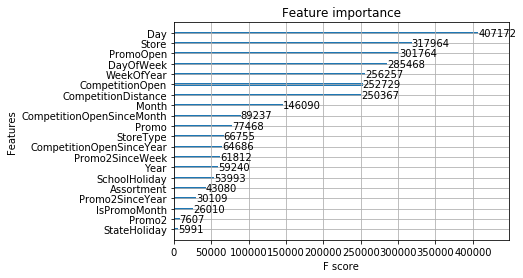

In [13]:
plot_importance(loaded_model)
plt.show()

In [16]:
y_pred = loaded_model.predict(xgb.DMatrix(x_valid))
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.1250


Best weight is 0.995, RMSPE is 0.1202


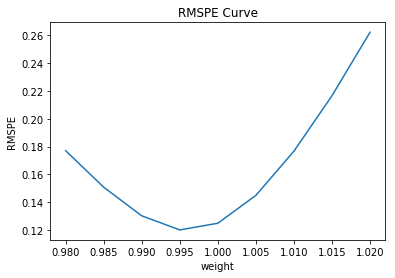

In [21]:
def correction():
    weights = np.arange(0.98, 1.02, 0.005)
    errors = []
    for w in weights:
        error = rmspe(np.expm1(y_valid), np.expm1(y_pred*w))
        errors.append(error)
        
    # 画一条曲线
    plt.plot(weights, errors)
    plt.xlabel('weight')
    plt.ylabel('RMSPE')
    plt.title('RMSPE Curve')
    # 输出最小误差
    idx = errors.index(min(errors))
    print('Best weight is {}, RMSPE is {:.4f}'.format(weights[idx], min(errors)))
    
correction()

In [17]:
dtest = xgb.DMatrix(x_test)

In [18]:
preds = loaded_model.predict(dtest)

In [19]:
result = pd.DataFrame({"Id": test_store["Id"],'Sales': np.expm1(preds*0.995)})
result.to_csv("submission_xgb-20190805-2.csv", index=False)


In [20]:
result = pd.read_csv("submission_xgb-20190805-2.csv")

In [21]:
#将预测的销售额再与测试集进行拼接，以此来分析预测的销售额走势
tmp_test_store=pd.merge(test_store,result,on='Id')

In [30]:

tmp_test_store.Date.unique()
#tmp_valid['Date']=pd.PeriodIndex(year=tmp_valid['Year'], month=tmp_valid['Month'], day=tmp_valid['Day'], freq="D")
#tmp_valid['Date']=datatime(tmp_valid['Year'],tmp_valid['Month'],tmp_valid['Day'])
#tmp_valid.columns

array(['2015-09-17', '2015-09-16', '2015-09-15', '2015-09-14',
       '2015-09-13', '2015-09-12', '2015-09-11', '2015-09-10',
       '2015-09-09', '2015-09-08', '2015-09-07', '2015-09-06',
       '2015-09-05', '2015-09-04', '2015-09-03', '2015-09-02',
       '2015-09-01', '2015-08-31', '2015-08-30', '2015-08-29',
       '2015-08-28', '2015-08-27', '2015-08-26', '2015-08-25',
       '2015-08-24', '2015-08-23', '2015-08-22', '2015-08-21',
       '2015-08-20', '2015-08-19', '2015-08-18', '2015-08-17',
       '2015-08-16', '2015-08-15', '2015-08-14', '2015-08-13',
       '2015-08-12', '2015-08-11', '2015-08-10', '2015-08-09',
       '2015-08-08', '2015-08-07', '2015-08-06', '2015-08-05',
       '2015-08-04', '2015-08-03', '2015-08-02', '2015-08-01'],
      dtype=object)

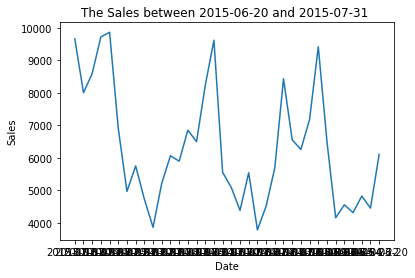

In [29]:
#从验证集valid_tmp 中任意选取一个商店，展示商店的销售额走势情况
#tmp_valid.Date.unique()

plt.plot(valid_tmp[valid_tmp.Store==215].Date,valid_tmp[valid_tmp.Store==215].Sales) 
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('The Sales between 2015-06-20 and 2015-07-31 ')
plt.show()

In [32]:
tmp_test_store[tmp_test_store.Store==215].columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'Day', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'monthStr',
       'IsPromoMonth', 'Sales'],
      dtype='object')

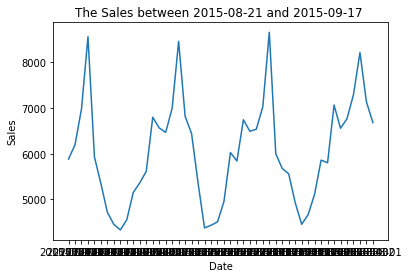

In [31]:
#tmp_new[tmp_new.Store==1].Sales
#tmp_new.columns
#为验证模型的稳定性，选取同样的商店，展示通过模型预测的销售额走势
plt.plot(tmp_test_store[tmp_test_store.Store==215].Date,tmp_test_store[tmp_test_store.Store==215].Sales) 
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('The Sales between 2015-08-21 and 2015-09-17 ')
plt.show()

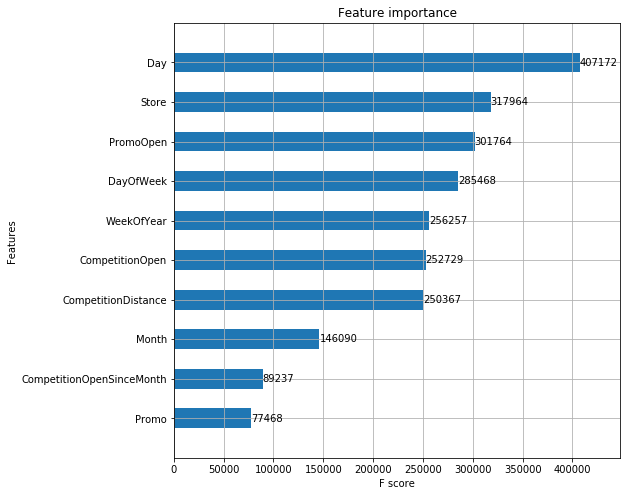

In [34]:
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(loaded_model, max_num_features= 10, height=0.5, ax=ax)
plt.show()

In [25]:
result

,Id,Sales
0,1,3793.1572
1,857,4014.5889
2,1713,4403.7890
3,2569,4808.6530
4,3425,5035.0093
5,4281,3744.0828
6,5137,3415.8345
7,5993,3306.8052
8,6849,3291.7825
9,7705,3593.4326


In [ ]:
dtrain = xgb.DMatrix(x_train_total, y_train_total)
dtest = xgb.DMatrix(x_test)
# specify parameters via map

params = {"objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.03,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 10   # Random number seed
          }
num_round = 2000
#model = xgb.train(params, dtrain, num_round)
#dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_valid, y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params, dtrain, num_round, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)
# make prediction
preds = model.predict(dtest)

In [ ]:
model.dump_model('model\dump.raw-2000-new3.txt')

In [ ]:
pickle.dump(model, open("model/rossmann.pickle-2000-new3.dat", "wb"))

In [ ]:
preds = model.predict(dtest)

In [ ]:
# make submission using best weight
result = pd.DataFrame({"Id": df_test["Id"],'Sales': np.expm1(preds*0.995)})
result.to_csv("submission_xgb-2000-new3.csv", index=False)



In [ ]:
result = pd.read_csv("submission_xgb-2000-new3.csv")

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(model, max_num_features= 10, height=0.5, ax=ax)
plt.show()

In [ ]:
result